In [1]:
%pylab inline
import scipy.optimize as opt
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0" 
from tardis import *
from scipy import sparse,ndimage

Populating the interactive namespace from numpy and matplotlib
Tensorflow Version:  1.15.0
Running TARDIS 2.1...


Using TensorFlow backend.


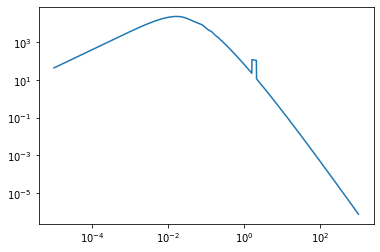

In [2]:
klin = np.loadtxt('F:/学习/天体物理/tardis-tf-master/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('F:/学习/天体物理/tardis-tf-master/data/Planck15_a1p00.txt').T[1]

plin[1300:1330] += 100#100
plt.loglog(klin,plin)
ipklin = iuspline(klin, plin)

In [3]:
n=16
uni = universe(bs=n, nc=n,z_f=2.0,ipklin = ipklin )
uni.evolv()

(16, 16, 16)
4096 65 4096
Total run time 0.8647346496582031


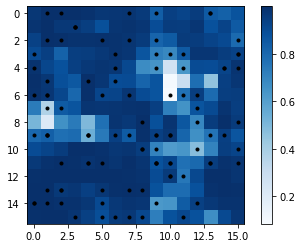

In [4]:
n_los = 100
mock_lya = lya_survey(uni,10,10,sm=0.5,n_skewers=n_los)
mock_lya.select_skewers()
imshow(np.exp(-1*uni.final_tau_RSD[0,:,:,0]),cmap="Blues")
colorbar()
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.')

In [ ]:
noise=mock_lya.inverse_covar
N = 1/noise.values
N = diagflat(N)

s = rand(size(uni.final_tau_RSD[0]))
d = mock_lya.vals_observed

The quantity to be optimized:
$$\chi^2 = (S_m(s) - s)^2 + (R(s) - d)^T N^{-1} (R(s)-d)$$
Let the partical number sidelength be $n_{c}$, number of skewers be $n_{los}$, $n_{c}^3 \equiv n, n_{los}\times n_{c}\equiv m$, then $S_m$ is a $n\times n$ matrix, $s$ is a $n \times 1$ vector, R is a $m \times n$ matrix, d is a $m \times 1$ vector.

The derivative of $\chi^2$:
$$\frac{\partial\chi^2}{\partial s}=2(S_m^T-I)(S_ms-s)+2R^TN^{-1}(Rs-d)$$


The response matrix $R$ selects the skewers.

In [60]:
data_coords = mock_lya.skewers_fin
# converse the index of (n,n,n) array to that of flattened array.
idx=data_coords[:,0]*n**2+data_coords[:,1]*n+data_coords[:,2]
# on  row number i of matrix R, there will be only one element whose value is 1 when its at column
# number idx[i], and all other elements are 0, so that this matrix can select skewers from whole field.
coo = sparse.coo_matrix((ones(n*n_los), (arange(n*n_los), idx)), shape=(n*n_los, n**3), dtype=int)
R=coo.todense()

The smooth operator $S_m$ acts as a gaussian filter to the reconstructed flux field s.

In [7]:
def smooth(x0,sigma=1):
    x=arange(-size(s)//2,size(s)//2)
    y = np.exp(-0.5 * (x-x0) ** 2 / sigma ** 2)
    return y/y.sum()

Sm = array([smooth(i) for i in range(-size(s)//2,size(s)//2)])
Sm.shape

(4096, 4096)

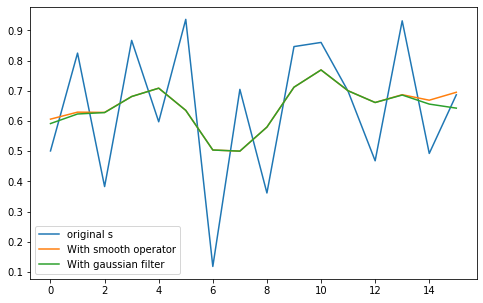

In [55]:
s = rand(n**3).reshape(-1,1)

figure(figsize=(8,5))
plot(s[:16],label='original s')
plot((Sm@s)[:16],label='With smooth operator')
plot(ndimage.gaussian_filter(s[:16],1),label='With gaussian filter')
legend()
show()

In [38]:
Loss = []
Ninv=inv(N)
d = d.reshape(-1,1)

#chi square
def obj_fun(s,Ninv,d,Sm):
    
    s=s.reshape(-1,1)
    term_1 = (Sm@s-s).T@(Sm@s-s)
    term_2 = 2*(d-R@s).T@Ninv@(d-R@s)
    loss = (term_1 + term_2)[0,0]
    Loss.append(loss)
    return loss

#the gradient function of chi square
def prime(s,Ninv,d,Sm):
    
    s=s.reshape(-1,1)
    term_1 = 2*(Sm.T-eye(len(Sm)))@(Sm@s-s)
    term_2 = R.T@Ninv@(R@s-d)
    gradient = term_1+term_2
    return np.ravel(gradient)

result = opt.fmin_l_bfgs_b(obj_fun, s,prime, args=(Ninv, d,Sm),maxiter=200)

print(obj_fun(result[0],Ninv,d,Sm))

778.2934483671928


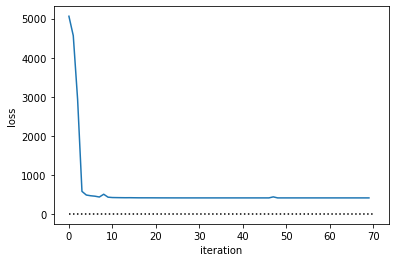

In [30]:
plt.plot(Loss)
hlines(0,0,len(Loss),linestyle=':')
ylabel('loss')
xlabel('iteration')
plt.show()

In [31]:
recon = result[0].reshape(n,n,n)
flux_true = exp(-1*uni.final_tau_RSD[0])

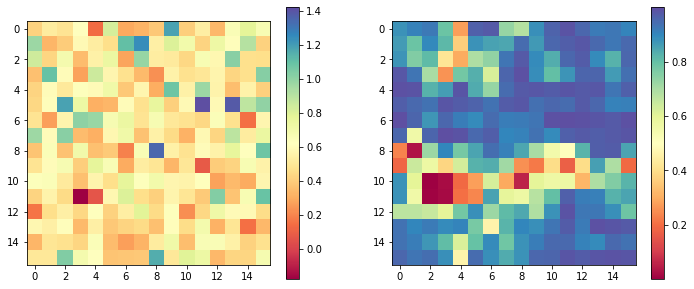

In [32]:
i=6
fig,ax=subplots(1,2,figsize=(12,5))
im1=ax[0].imshow(recon[:,:,i],cmap='Spectral')

im2=ax[1].imshow(flux_true[:,:,i],cmap='Spectral')
colorbar(im2,ax=ax[1])
colorbar(im1,ax=ax[0])

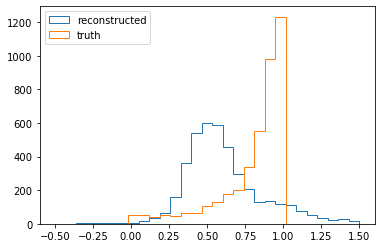

In [66]:
bins=linspace(-0.5,1.5,30)
hist(recon.flatten(),bins,histtype='step',label='reconstructed')
hist(flux_true.flatten(),bins,histtype='step',label='truth')
legend(loc=2)
show()